# Notebook showing a fast and efficient way to load Sentinel-2 L1C data into xarray

In [1]:
import glob
import os
import numpy as np

import pandas as pd
import geopandas as gpd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
from s2driver import driver_S2_SAFE as S2

import memory_profiler

from eoreader.keywords import CLEAN_OPTICAL
%load_ext memory_profiler


opj = os.path.join

Set the path of the images you want to load, here is a example for the former (v3) and current (v4) image formatting 

In [2]:
imageSAFE_v3 = '/sat_data/satellite/sentinel2/L1C/31TFJ/S2A_MSIL1C_20201004T104031_N0209_R008_T31TFJ_20201004T125253.SAFE'
imageSAFE_v4 = '/sat_data/satellite/sentinel2/L1C/31TFJ/S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T124834.SAFE'
imageSAFE_v4 ='/media/harmel/vol1/Dropbox/satellite/S2/L1C/S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T124834.SAFE'

First, check the availbale bands:

In [3]:
S2.INFO

bandId            0     1      2    3      4      5      6           7    8   \
ESA              B01   B02    B03  B04    B05    B06    B07         B08  B8A   
EOREADER          CA  BLUE  GREEN  RED  VRE_1  VRE_2  VRE_3  NARROW_NIR  NIR   
Wavelength (nm)  443   490    560  665    705    740    783         842  865   
Band width (nm)   20    65     35   30     15     15     20         115   20   
Resolution (m)    60    10     10   10     20     20     20          10   20   

bandId            9            10      11      12  
ESA              B09          B10     B11     B12  
EOREADER          WV  SWIR_CIRRUS  SWIR_1  SWIR_2  
Wavelength (nm)  945         1375    1610    2190  
Band width (nm)   20           30      90     180  
Resolution (m)    60           60      20      20

Choose the bands to be loaded (fill the bandIds array up) and the resolution between 10, 20 and 60 m:

In [4]:
bandIds = [0,1,2,3,8,11,12]
resolution=60

Create the s2driver objects for the selected images

In [5]:
image = imageSAFE_v4
l1c = S2.s2image(image,band_idx=bandIds,resolution=resolution)


In [6]:
l1c.band_idx

[0, 1, 2, 3, 8, 11, 12]

In [7]:
l1c.proj

<Derived Projected CRS: +proj=utm +ellps=WGS84 +units=m +zone=31 +no_defs  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

From that stage you can check some metadata such as the crs and geometry related attributes:

In [11]:
l1c.metadata2['n1:Level-1C_User_Product'][
    'n1:General_Info']['Product_Image_Characteristics']['Spectral_Information_List']['Spectral_Information']

[{'@bandId': '0',
  '@physicalBand': 'B1',
  'RESOLUTION': '60',
  'Wavelength': {'MIN': {'@unit': 'nm', '#text': '411'},
   'MAX': {'@unit': 'nm', '#text': '456'},
   'CENTRAL': {'@unit': 'nm', '#text': '442.3'}},
  'Spectral_Response': {'STEP': {'@unit': 'nm', '#text': '1'},
   'VALUES': '0.0062411 0.01024045 0.00402983 0.00642179 0.00552753 0.0065525 0.00409887 0.006297 0.00436742 0.00233356 0.00058162 0.00202276 0.00294328 0.00485362 0.00317041 0.00237657 0.00234612 0.00440152 0.01292397 0.05001678 0.18650104 0.45441623 0.72307877 0.83999211 0.86456334 0.87472096 0.89215296 0.91090814 0.92588017 0.93924094 0.94491826 0.95078529 0.96803023 0.99939195 1 0.97548364 0.96148351 0.94986211 0.91841452 0.87989802 0.80383677 0.59752075 0.30474132 0.10798014 0.0304465 0.00885119'}},
 {'@bandId': '1',
  '@physicalBand': 'B2',
  'RESOLUTION': '10',
  'Wavelength': {'MIN': {'@unit': 'nm', '#text': '456'},
   'MAX': {'@unit': 'nm', '#text': '532'},
   'CENTRAL': {'@unit': 'nm', '#text': '492.3'}

In [18]:
SRFs=[]
wl_hr=np.arange(400,2350)
for _ in l1c.metadata2['n1:Level-1C_User_Product'][
    'n1:General_Info']['Product_Image_Characteristics']['Spectral_Information_List']['Spectral_Information']:
    bandID = int(_['@bandId'])
    if not l1c.band_idx.__contains__(bandID):
        continue
    wl_min,wl_max = float(_['Wavelength']['MIN']['#text']),float(_['Wavelength']['MAX']['#text'])
    step = float(_['Spectral_Response']['STEP']['#text'])
    wl=np.arange(wl_min,wl_max+step,step)
    RSF=np.asarray(_['Spectral_Response']['VALUES'].split(), dtype=np.float32)
    SRFs.append(xr.DataArray(RSF,coords=dict(wl_hr=wl),name='SRF').interp(wl_hr=wl_hr).assign_coords(dict(wl=_['@physicalBand'])))
SRFs=xr.concat(SRFs,dim='BandID')
SRFs.attrs['description']='Spectral response function of each band'

In [15]:
l1c.

True

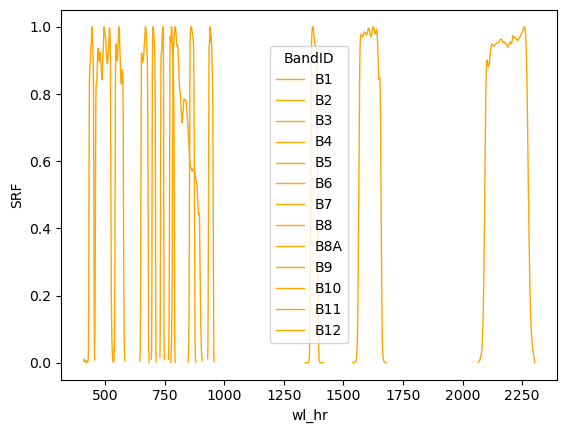

In [10]:

SRFs.plot(x='wl_hr',hue='BandID',color='orange',lw=1)

Load band reflectances and geometry into the *prod* xarray 


In [6]:
from eoreader.products import CleanMethod
%time %memit l1c.load_product(**{CLEAN_OPTICAL: CleanMethod.RAW})

peak memory: 2193.60 MiB, increment: 1798.47 MiB
CPU times: user 3min 6s, sys: 7.65 s, total: 3min 14s
Wall time: 20.6 s


In [7]:
l1c.prod

<xarray.Dataset>
Dimensions:      (x: 1830, y: 1830, wl: 7, wl_hr: 1950)
Coordinates:
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
  * wl           (wl) object 443 490 560 665 865 1610 2190
    spatial_ref  int64 0
  * wl_hr        (wl_hr) int64 400 401 402 403 404 ... 2345 2346 2347 2348 2349
Data variables:
    bands        (wl, y, x) float32 0.1422 0.1449 0.1473 ... -0.1 -0.1 -0.1
    vza          (wl, y, x) float32 3.697 3.701 3.705 3.71 ... nan nan nan nan
    raa          (wl, y, x) float64 161.2 161.2 161.2 161.1 ... nan nan nan nan
    sza          (y, x) float64 28.98 28.97 28.97 28.97 ... 27.6 27.6 27.6 27.6
    SRF          (wl, wl_hr) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/34)
    CLOUD_COVERAGE_ASSESSMENT:           0.0
    DATATAKE_1_DATATAKE_SENSING_START:   2022-07-31T10:36:29.024Z
    DATATAKE_1_DATATAKE_TYPE:            INS-NOBS
    DATATAKE_1_ID:                       GS2B_20220731T103629_028205_N04.00
    DATATAKE_1_SENSING_ORBIT_DIRECTION:  DESCENDING
    DATATAKE_1_SENSING_ORBIT_NUMBER:     8
    ...                                  ...
    SPECIAL_VALUE_NODATA:                0
    SPECIAL_VALUE_SATURATED:             65535
    satellite:                           S2B
    solar_irradiance:                    [1874.3  1959.75 1824.93 1512.79 142...
    solar_irradiance_unit:               W/m²/µm
    acquisition_date:                    2022-07-31T10:36:29.024Z

# Plotting section
The MSI-Sentinel-2 instrument is composed of 12 detectors staggered in two different rows making a "switch" in viewng geometries along the image especially for the azimuth values. Here, we plot the solar and viewing zenith angles as well as the relative azimuth between Sun and sensor directions.
The sun viewing angle (SZA) is common to all the spectral bands.

In [7]:
l1c.proj.to_proj4

<bound method CRS.to_proj4 of <Derived Projected CRS: +proj=utm +ellps=WGS84 +units=m +zone=31 +no_defs  ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
>

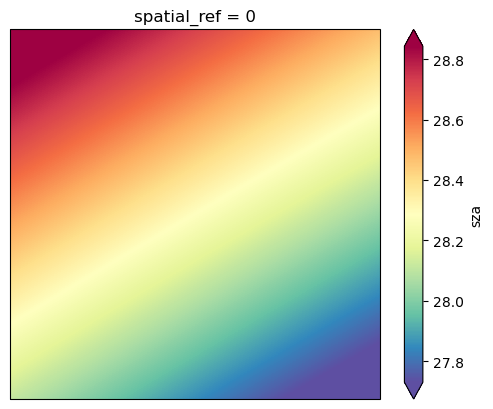

In [8]:
coarsening = 10
p = l1c.prod.sza[::coarsening, ::coarsening].plot.imshow(subplot_kws=dict(projection= l1c.proj), robust=True, cmap=plt.cm.Spectral_r)

The sensor angles are dependent on the spectral band considered, here are the viewing zenith angle (VZA) and the relative azimuth (RAZI) for the bands loaded in the S2 object.
## VZA

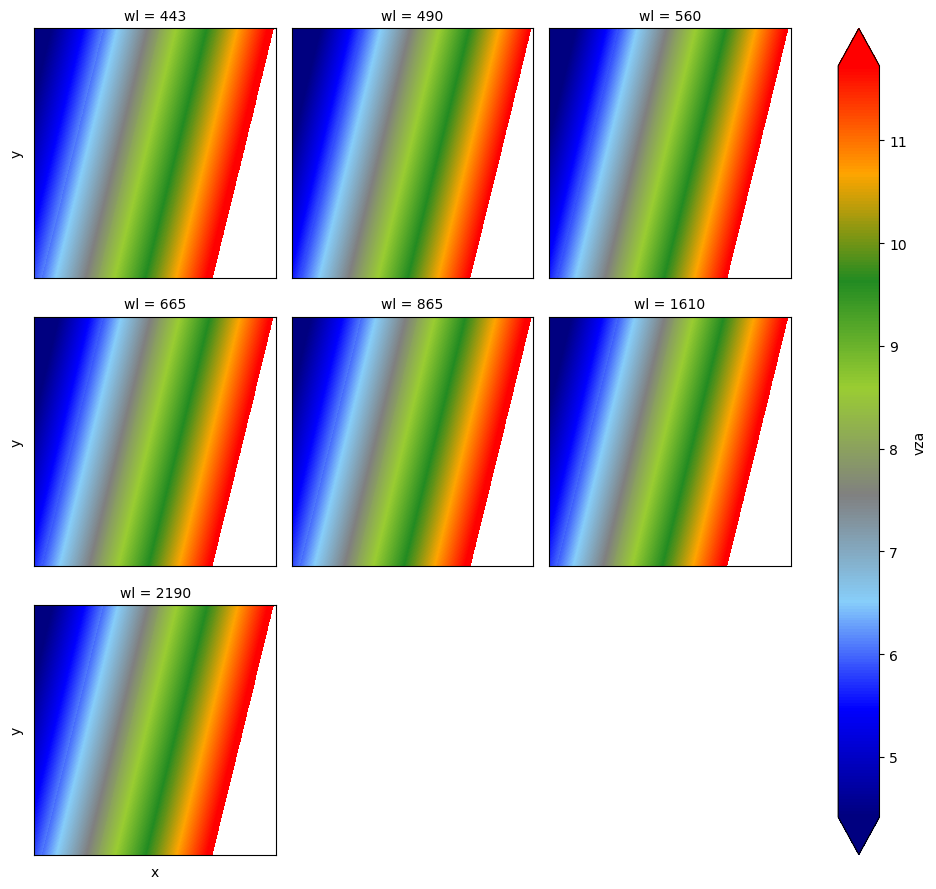

In [10]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("",['navy', "blue", 'lightskyblue', 'gray', 'yellowgreen', 'forestgreen', 'orange', 'red'])
fig = l1c.prod.vza.plot.imshow(col='wl', cmap=cmap, col_wrap=3,  robust=True,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

## RAZI

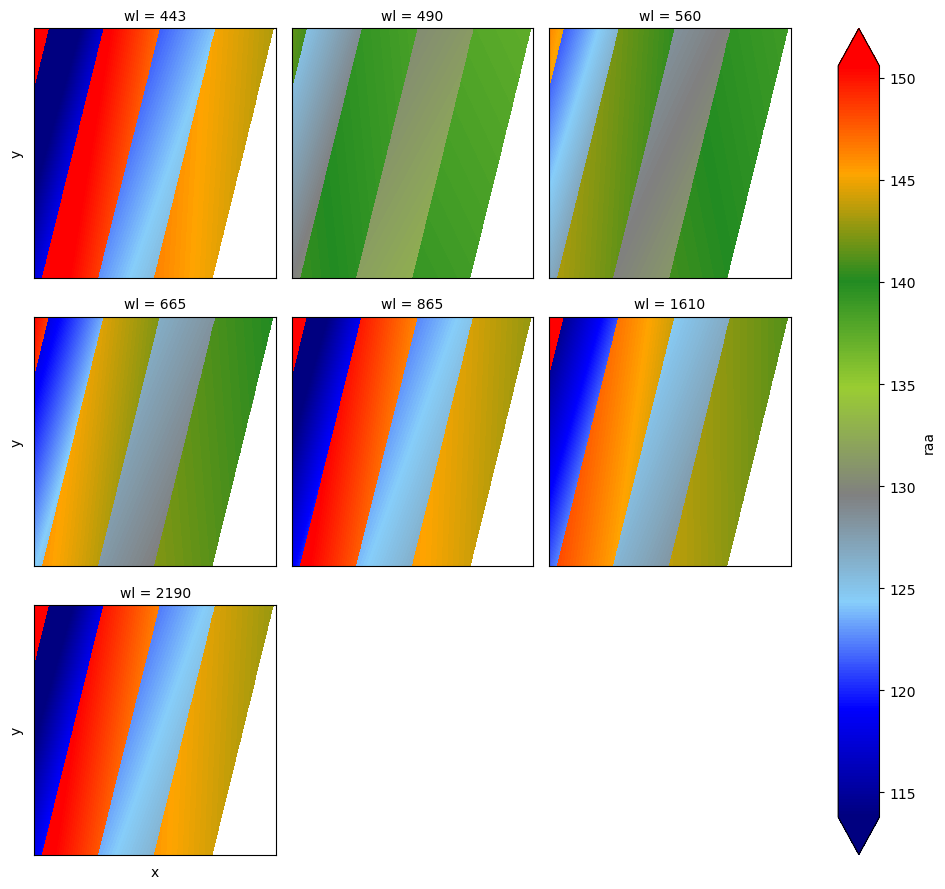

In [11]:
fig = l1c.prod.raa.plot.imshow(col='wl', cmap=cmap, col_wrap=3, aspect=1, robust=True,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

Check the difference between two bands (e.g., B02-B8A)

In [12]:
param='vza'
diff_vza = l1c.prod[param].sel(wl=490)-l1c.prod[param].sel(wl=865)
param='raa'
diff_raa = l1c.prod[param].sel(wl=490)-l1c.prod[param].sel(wl=865)


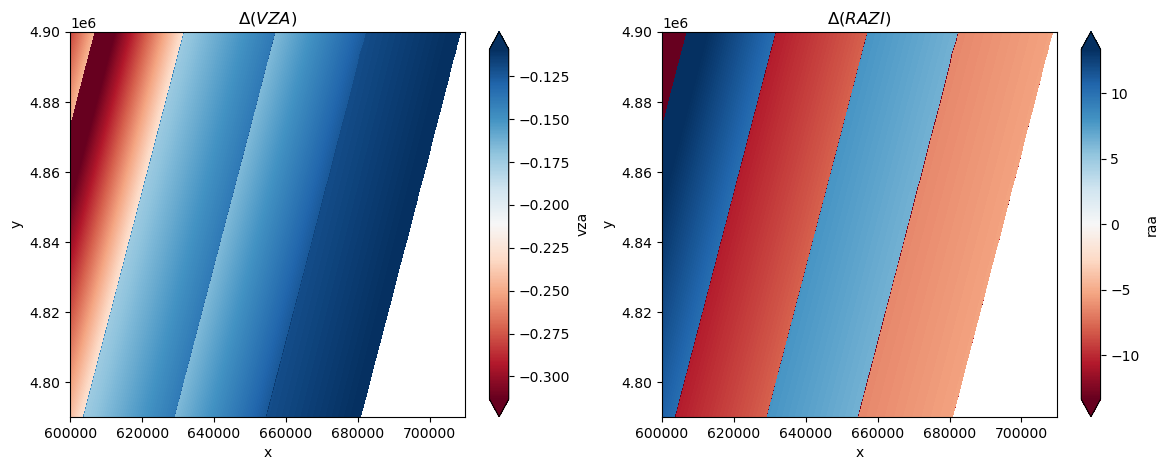

In [13]:
fig, axs = plt.subplots(ncols=2,figsize=(14,5))
diff_vza.plot.imshow(ax=axs[0],cmap=plt.cm.RdBu, robust=True)
axs[0].set_title('$\Delta (VZA)$')
diff_raa.plot.imshow(ax=axs[1],cmap=plt.cm.RdBu, robust=True)
axs[1].set_title('$\Delta (RAZI)$')
plt.show()

The reflectance data can also be easily plotted:

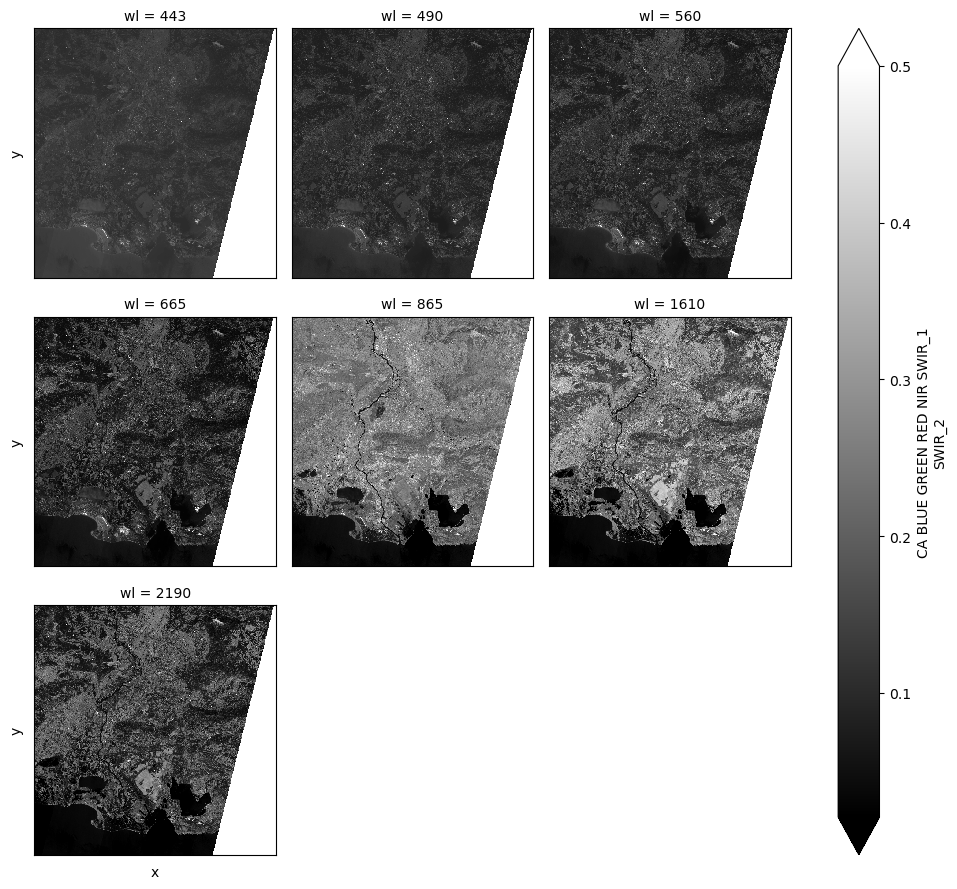

In [15]:

p = l1c.prod.bands[:, ::coarsening, ::coarsening].plot.imshow(col='wl', col_wrap=3,  vmax=0.5, robust=True, cmap=plt.cm.binary_r,subplot_kws=dict(xlabel='',xticks=[], yticks=[]))

And the RGB image:

In [16]:
l1c.prod.bands

<xarray.DataArray 'bands' (wl: 7, y: 5490, x: 5490)>
array([[[0.1422  , 0.1422  , 0.1431  , ...,      nan,      nan,
              nan],
        [0.1422  , 0.1422  , 0.1431  , ...,      nan,      nan,
              nan],
        [0.1419  , 0.1419  , 0.1428  , ...,      nan,      nan,
              nan],
        ...,
        [0.1315  , 0.1315  , 0.1314  , ...,      nan,      nan,
              nan],
        [0.1315  , 0.1315  , 0.1314  , ...,      nan,      nan,
              nan],
        [0.1315  , 0.1315  , 0.1314  , ...,      nan,      nan,
              nan]],

       [[0.13825 , 0.13225 , 0.13365 , ...,      nan,      nan,
              nan],
        [0.145   , 0.14505 , 0.1333  , ...,      nan,      nan,
              nan],
        [0.148375, 0.144875, 0.131075, ...,      nan,      nan,
              nan],
...
        [0.0286  , 0.027   , 0.027   , ...,      nan,      nan,
              nan],
        [0.0277  , 0.0271  , 0.0277  , ...,      nan,      nan,
              nan],
        [0.0279  , 0.028   , 0.0271  , ...,      nan,      nan,
              nan]],

       [[0.2421  , 0.2323  , 0.2206  , ...,      nan,      nan,
              nan],
        [0.2516  , 0.2481  , 0.2185  , ...,      nan,      nan,
              nan],
        [0.259   , 0.2609  , 0.2185  , ...,      nan,      nan,
              nan],
        ...,
        [0.023   , 0.0211  , 0.0221  , ...,      nan,      nan,
              nan],
        [0.0231  , 0.0219  , 0.0212  , ...,      nan,      nan,
              nan],
        [0.0223  , 0.0217  , 0.0204  , ...,      nan,      nan,
              nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
  * wl           (wl) object 443 490 560 665 865 1610 2190
    spatial_ref  int64 0
    bandID       (wl) object 'B01' 'B02' 'B03' 'B04' 'B8A' 'B11' 'B12'
Attributes: (12/13)
    long_name:         CA BLUE GREEN RED NIR SWIR_1 SWIR_2
    constellation:     Sentinel-2
    constellation_id:  S2
    product_path:      /media/harmel/vol1/Dropbox/satellite/S2/L1C/S2B_MSIL1C...
    product_name:      S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T...
    product_filename:  S2B_MSIL1C_20220731T103629_N0400_R008_T31TFJ_20220731T...
    ...                ...
    product_type:      MSIL1C
    acquisition_date:  20220731T103629
    condensed_name:    20220731T103629_S2_T31TFJ_L1C_124834
    orbit_direction:   DESCENDING
    radiometry:        reflectance
    cloud_cover:       0.0

In [19]:
# Get geographic projection and bounds
extent = l1c.extent
proj = l1c.proj
bounds = extent.bounds
extent_val = [bounds.minx[0]+20000, bounds.maxx[0]-30000, bounds.miny[0], bounds.maxy[0]-50000]


Text(0.5, 1.0, '')

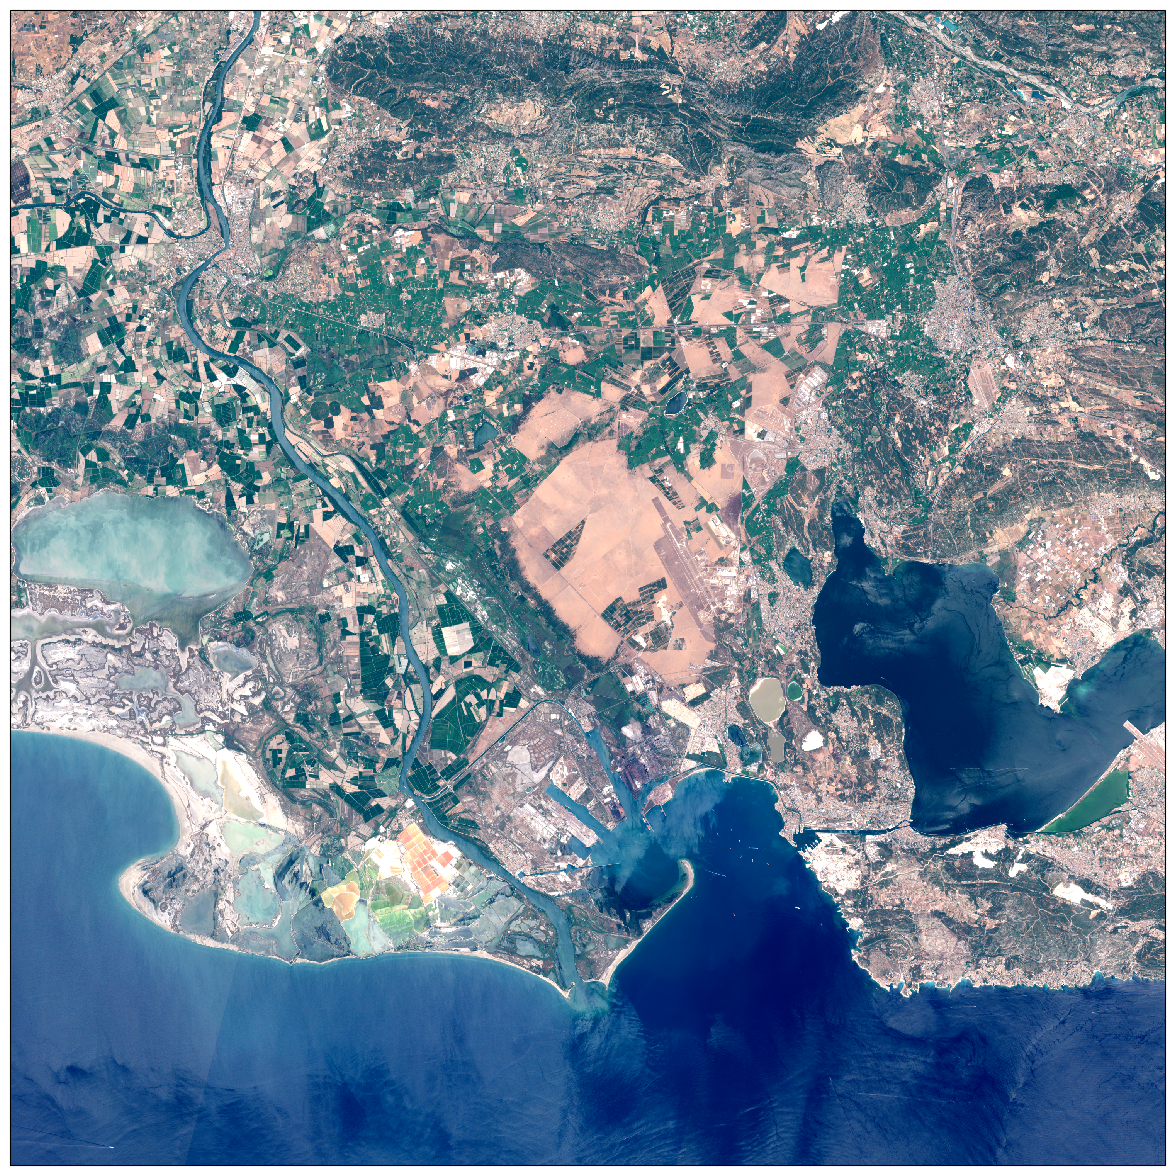

In [20]:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1, projection=proj)
ax.set_extent(extent_val, proj)
coarsening=1
brightness_factor = 3.5
(l1c.prod.bands[:, ::coarsening, ::coarsening].sel(wl=[665,560,490])**0.5**brightness_factor
).plot.imshow(rgb='wl', robust=True,subplot_kws=dict(projection= l1c.proj))
ax.set_title('')

## Example of exploiation: compute NDWI for water pixel masking

In [52]:

# Compute NDWI
green = l1c.bands.sel(wl=490)
nir = l1c.bands.sel(wl=2190)
ndwi = (green - nir) / (green + nir)


def water_mask(ndwi, threshold=0):
    water = xr.where(ndwi > threshold, 1, 0)
    return water.where(~np.isnan(ndwi))


In [18]:
bounds

NameError: name 'bounds' is not defined

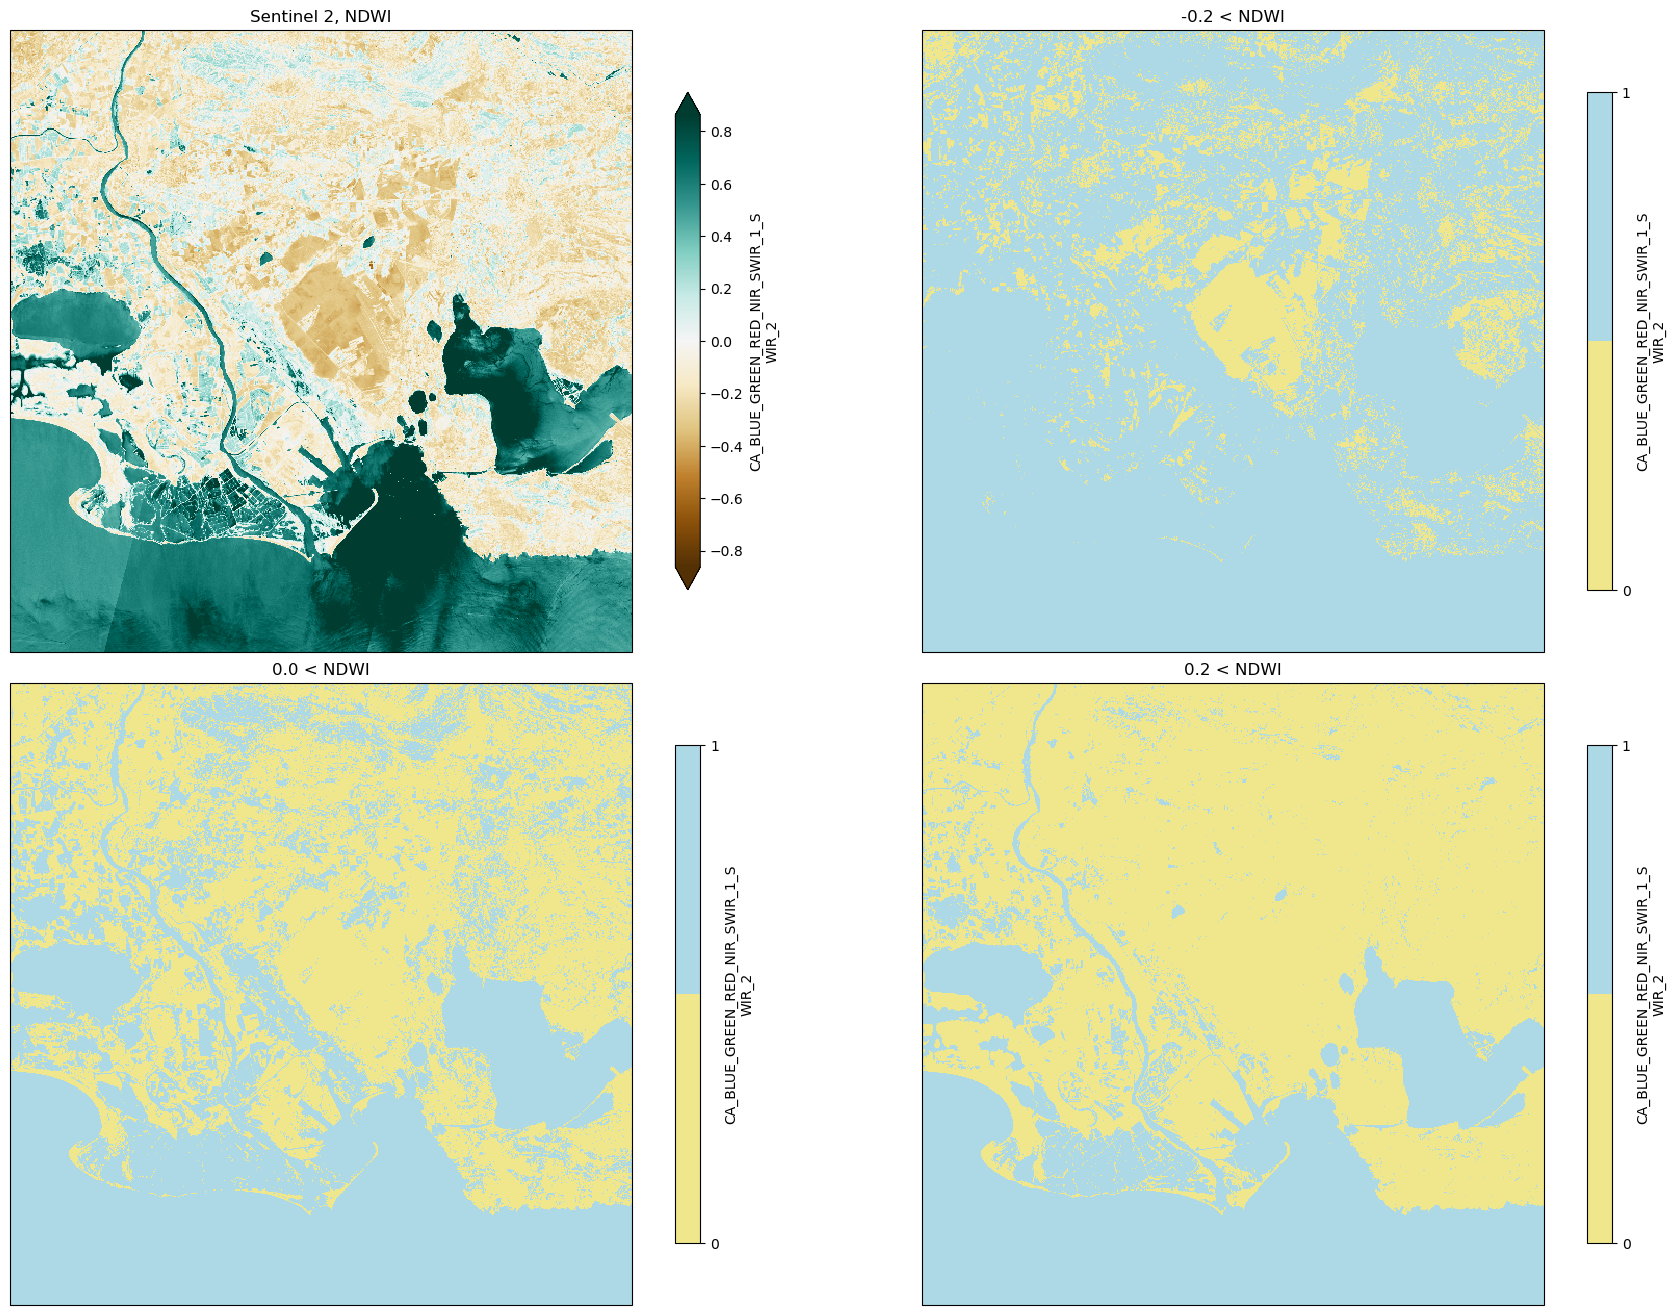

In [54]:
#coarsening to save memory and speed
coarsening=5
ndwi_ = ndwi[::coarsening, ::coarsening]

# Get geographic projection and bounds
extent = l1c.extent
proj = l1c.proj
bounds = extent.bounds
extent_val = [bounds.minx[0]+20000, bounds.maxx[0]-30000, bounds.miny[0], bounds.maxy[0]-50000]

# binary cmap
bcmap = ListedColormap(['khaki', 'lightblue'])


def water_mask(ndwi, threshold=0):
    water = xr.where(ndwi > threshold, 1, 0)
    return water.where(~np.isnan(ndwi))

def plot_water_mask(ndwi,ax,threshold=0):
    water = water_mask(ndwi, threshold)
    ax.set_extent(extent_val, proj)
    water.plot.imshow(extent=extent_val, transform=proj, cmap=bcmap,
                                  cbar_kwargs={'ticks': [0, 1], 'shrink': shrink})
    ax.set_title(str(threshold)+' < NDWI')

fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.99,
                    hspace=0.05, wspace=0.05)
shrink = 0.8
    
ax = plt.subplot(2, 2, 1, projection=proj)
ax.set_extent(extent_val, proj)
fig = ndwi[::coarsening, ::coarsening].plot.imshow(extent=extent_val, transform=proj, cmap=plt.cm.BrBG, robust=True,
                                   cbar_kwargs={'shrink': shrink})
# axes.coastlines(resolution='10m',linewidth=1)
ax.set_title('Sentinel 2, NDWI')

for i,threshold in enumerate([-0.2,0.,0.2]):
    ax = plt.subplot(2, 2, i+2, projection=proj)
    plot_water_mask(ndwi_,ax,threshold=threshold)

plt.show()
